In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.distributions import Normal
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils_BL as rl_utils

In [2]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_hidden1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_hidden3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_hidden4 = torch.nn.Linear(hidden_dim, hidden_dim)
        # self.fc_hidden1 = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        # self.fc_hidden2 = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        # self.fc_hidden3 = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc_hidden1(x))
        x = F.relu(self.fc_hidden2(x))
        # x = F.relu(self.fc_hidden3(x))     
        # x = F.relu(self.fc_hidden4(x))  
        # x = self.fc_hidden1(x)
        # x = self.fc_hidden2(x)
        # x = self.fc_hidden3(x)
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action_bound_tensor = torch.tensor(self.action_bound).unsqueeze(0).to(action.device)
        action = action * action_bound_tensor
        return action.float(), log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc_hidden1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
        # self.fc_hidden3 = torch.nn.Linear(hidden_dim, hidden_dim)
        # self.fc_hidden4 = torch.nn.Linear(hidden_dim, hidden_dim)
        # self.fc_hidden1 = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        # self.fc_hidden2 = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        # self.fc_hidden3 = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim),
        #     nn.LayerNorm(hidden_dim),
        #     nn.ReLU()
        # )
        
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        # cat = torch.cat([x, a], dim=1)
        # cat = torch.cat([x.unsqueeze(0), a.unsqueeze(0)], dim=1)
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc_hidden1(x))
        x = F.relu(self.fc_hidden2(x))
        # x = F.relu(self.fc_hidden3(x)) 
        # x = F.relu(self.fc_hidden4(x)) 
        # x = self.fc_hidden1(x)
        # x = self.fc_hidden2(x)
        # x = self.fc_hidden3(x)
        return self.fc_out(x)

In [3]:
class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0].float()
        result_list = action.squeeze(0).tolist()
        # return [action.item()]
        return result_list

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # 和之前章节一样,对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

1. actor_lr = 5e-3 critic_lr = 5e-3 `alpha_lr = 5e-15` num_episodes = 500 hidden_dim = 64 gamma = 0.9 tau = 0.005  # 软更新参数 buffer_size = 10000 minimal_size = 1000 batch_size = 256 成功率35%
1. actor_lr = 5e-3 critic_lr = 5e-3 `alpha_lr = 5e-15` num_episodes = 500 hidden_dim = 64 gamma = 0.9 tau = 0.005  # 软更新参数 buffer_size = 10000 minimal_size = 1000 batch_size = 256 成功率37%
1. `actor_lr = 3e-3 critic_lr = 3e-3` `alpha_lr = 5e-15` num_episodes = 500 `hidden_dim = 128` gamma = 0.9 tau = 0.005  # 软更新参数 buffer_size = 10000 minimal_size = 1000 batch_size = 256 hide = 3 成功率37
1. actor_lr = 5e-3 critic_lr = 5e-3 `alpha_lr = 3e-15` num_episodes = 500 `hidden_dim = 128` gamma = 0.9 tau = 0.005  # 软更新参数 buffer_size = 20000 minimal_size = 2000 batch_size = 256 hide = 4 (单层) 成功率83%

In [4]:
from env.water_env_ppo import FlowEnv as lenv
# env_name = 'Pendulum-v0'
# env = gym.make(env_name)
levelcount = 2
turn_max_time = 5
flow_erro = 0.02 #误差5%
meted='SAC'

env = lenv(levelcount = levelcount, turn_time=turn_max_time,flow_erro =flow_erro,adjust_max_count=200,meted='SAC')  
# env._BaseLine_controal()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high  # 动作最大值  

actor_lr = 5e-3
critic_lr = 5e-3
alpha_lr = 3e-15
num_episodes = 500
hidden_dim = 128
gamma = 0.9
tau = 0.005  # 软更新参数
buffer_size = 20000
minimal_size = 2000
batch_size = 256
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)
return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Jinzhao_hu\AppData\Local\Temp\ipykernel_37844\1694584089.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 0:  18%|█▊        | 9/50 [00:09<00:45,  1.11s/it]C:\Users\Jinzhao_hu\AppData\Local\Temp\ipykernel_37844\1694584089.py:77: UserWarning: Using a target size (torch.Size([256, 2])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(self.critic_1(states, actions), td_target.detach()))
C:\Users\Jinzhao_hu\AppData\Local\Temp\ipykernel_37844\1694584089.py:79: UserWarning: Using a target siz

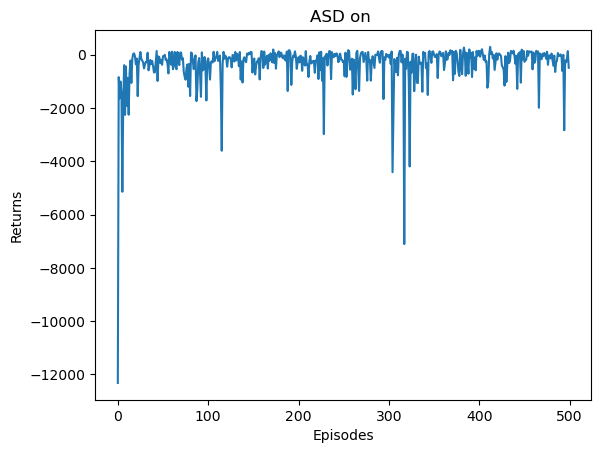

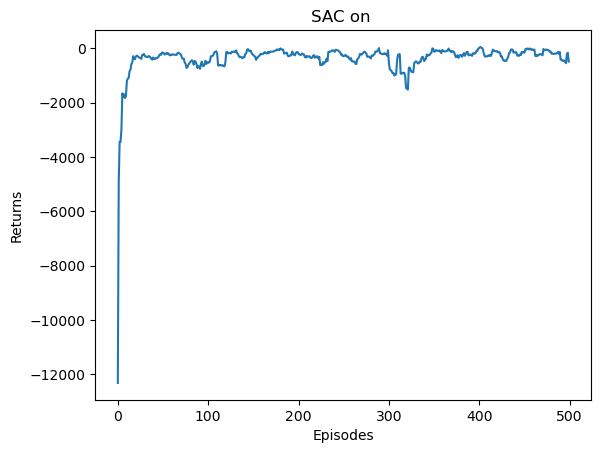

In [5]:
import pandas as pd

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('ASD on {}'.format(''))
plt.show()

# 创建一个字典，将数据整理成适合构建DataFrame的数据结构
data = {
    "Episodes": episodes_list,
    "Returns": return_list
}

# 使用字典创建DataFrame对象
df = pd.DataFrame(data)
# 创建只有一列数据的DataFrame
df = pd.DataFrame({"Returns": return_list})

# 将DataFrame保存为Excel文件，指定文件名为output.xlsx
df.to_excel(f"{levelcount}_SAC_reward.xlsx", index=False)

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(''))
plt.show()

## 1.2 保存模型

In [31]:
torch.save(agent, f'model_{levelcount}_SAC.pt')

## 1.3 加载模型

In [32]:
levelcount = 2
meted = "SAC"

In [33]:

agent = torch.load(f'model_{levelcount}_SAC.pt')

## 1.4 仿真验证

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from env.water_env_ppo import FlowEnv as lenv

In [35]:

turn_max_time = 5
env = lenv(levelcount = levelcount, turn_time=turn_max_time, flow_erro=0.05,adjust_max_count=100, meted='SAC') 
# 
reward_list = np.array([])
Q_list = np.array([])
ta_list = np.array([])
#提取一个数据集
data = pd.read_excel(f'state_data_{levelcount}.xlsx')
# train_count = data.shape[0]
train_count = 99
for i in np.arange(train_count):
    data_row =np.array(data.iloc[i].values) 
    #data_row =np.array(data.iloc[59].values) 
    state =env.install(state =  data_row)
    done = False
    while not done:
        action = agent.take_action(state) #计算策略动作
        next_state, reward, done, _ = env.step(action)
        state = next_state
        reward_list = np.append(reward_list,reward)
    #翻译Q和ta
    temp_Qlist = np.array([])
    temp_ta = np.array([])
    sate_tran = env.trans_state(state)
    for i in np.arange(levelcount):
        temp_Qlist = np.append(temp_Qlist,sate_tran[4+i*5])
        temp_ta = np.append(temp_ta,sate_tran[5+i*5])      
    Q_list = np.concatenate((Q_list,temp_Qlist),axis=0)
    ta_list = np.concatenate((ta_list,temp_ta),axis=0)
Q_list = Q_list.reshape(-1,levelcount)
ta_list = ta_list.reshape(-1,levelcount)
# print (f'Q:{Q_list}')
# print (f'ta:{ta_list}')
# # print (f'ta:{reward_list}')

### 1.4.1 奖励函数

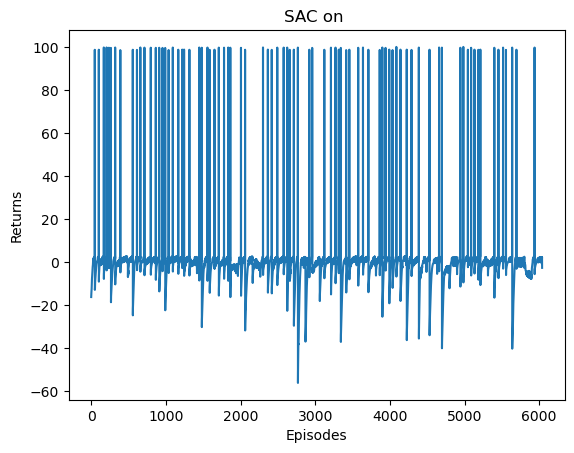

In [36]:
episodes_list = list(range(len(reward_list)))
plt.plot(episodes_list, reward_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(''))
plt.show()

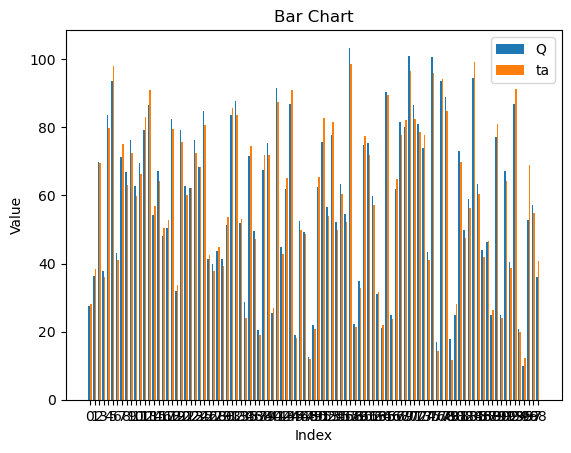

误差:0.05028659019188759


In [37]:
# 示例数据
# x = np.arange(train_count)
y1 = Q_list  # 第一组数据
y2 = ta_list  # 第二组数据

# 设置柱体的宽度
x = np.arange(y1.shape[0])
# Set width for bars
width = 0.35

# Plot y1 and y2 together
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1[:,0], width, label='Q')
rects2 = ax.bar(x + width/2, y2[:,0], width, label='ta')
# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Bar Chart')
ax.set_xticks(x)
ax.legend()

plt.show()
#平均误差
result =np.abs(y2-y1)/y2
# print(result)
# erro_avr =np.mean(np.sum(result)) 
erro_avr =np.sum(result)/(train_count*levelcount)  
print(f'误差:{erro_avr}')
df = pd.DataFrame(result)
df.to_excel(f'{levelcount}_{meted}_errodata.xlsx', index=False,header=False)

### 1.4.3调整平均次数

In [38]:
from openpyxl import load_workbook

# 打开Excel文件
workbook = load_workbook(f'{levelcount}_SAC_RL_done.xlsx')

# 获取第一个工作表
sheet = workbook.active
# 从第二行开始，遍历第一列的所有单元格，取值并求和

sum_value = 0
count = 0
for row in sheet.iter_rows(min_row=2, min_col=1, max_col=1, values_only=True):
   if row[0] is not None and row[0] != 100:
        sum_value += row[0]
        count += 1
# 计算平均值
if count>0 :  
  average = sum_value / count
  print("和：", sum_value)
  print("平均值：", average)
  print('成功率：',count/train_count)

和： 4241
平均值： 51.71951219512195
成功率： 0.8282828282828283
